# Load Libraries

In [86]:
!pip install google-cloud-translate
!pip install google-cloud-translate pandas tqdm

# install simpletransformers
!pip install simpletransformers
# check installed version
!pip freeze | grep simpletransformers
!pip install seaborn

simpletransformers==0.70.1


In [87]:
# System and OS imports
import os

# General libraries for data manipulation and progress tracking
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from collections import Counter

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Google Cloud services for translation
from google.cloud import translate_v2 as translate
from google.colab import files

# NLTK libraries for natural language processing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Sklearn libraries for text vectorization and machine learning models
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Additional libraries for data processing and cleaning
import string
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Data exploration and preprocessing

## Load Data

In [88]:
splits = {'train': 'training set.csv', 'test': 'testing set.csv'}
train = pd.read_csv("hf://datasets/thefrankhsu/hate_speech_twitter/" + splits["train"])
test = pd.read_csv("hf://datasets/thefrankhsu/hate_speech_twitter/" + splits["test"])

In [89]:
# concatenate the dataset
df = pd.concat([train, test], axis=0)

In [90]:
df.head(5)

,tweet,label,categories
0,krazy i dont always get drunk and pass out but...,0,NaN
1,white kids favorite activities calling people ...,1,Race
2,maam did you clear that tweet with the caref...,0,NaN
3,wth is that playing missy i mean seriously rt...,0,NaN
4,he promised to stand with the muzzies so,0,NaN


In [91]:
# shape of the dataset
print(df.shape)
print("\n-------------------------------------------------")
# total number of unique categories
print("Unique Lables:",df['label'].nunique())
print("Unique categories:",df['categories'].nunique())
print("-------------------------------------------------")


(6679, 3)

-------------------------------------------------
Unique Lables: 2
Unique categories: 9
-------------------------------------------------


In [92]:
# Check null rows
df['tweet'].isnull().value_counts()

,count
tweet,
False,6678
True,1


In [93]:
# Delete null row
df = df.dropna(subset=['tweet'])

In [94]:
# Count the unique number of categories
df["label"].value_counts()

,count
label,
0,4662
1,2016


In [95]:
# Replace null category column with "None"
df["categories"] = df["categories"].fillna("None")

# Count the unique number of categories
df["categories"].value_counts()

,count
categories,
None,4662
Race,587
Sexual Orientation,485
Gender,335
Physical Appearance,129
Religion,104
Disability,94
Class,94
Ethnicity,94


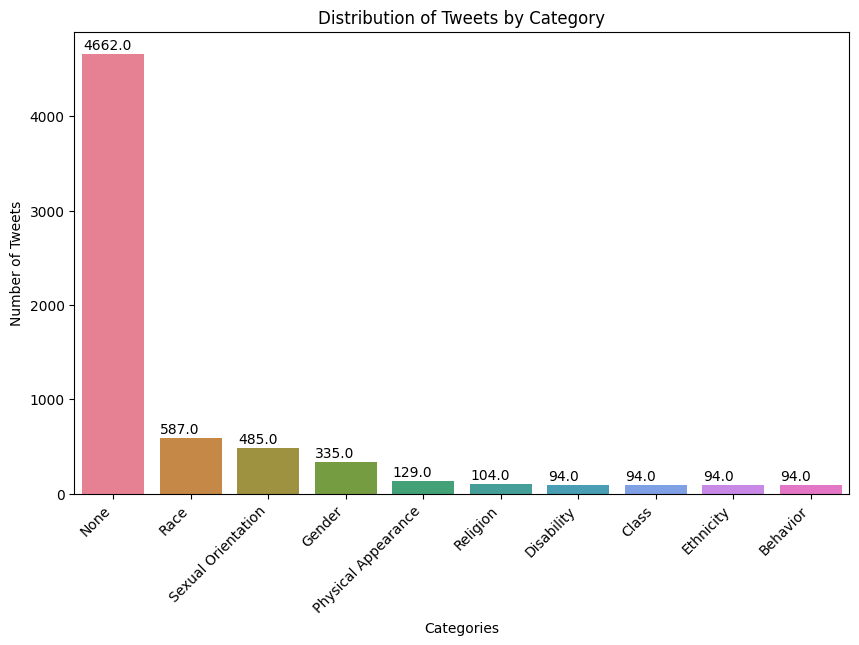

In [96]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
          x=df['categories'].value_counts().index,
          y=df['categories'].value_counts().values,
          palette="husl")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))

plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Category')
plt.show()

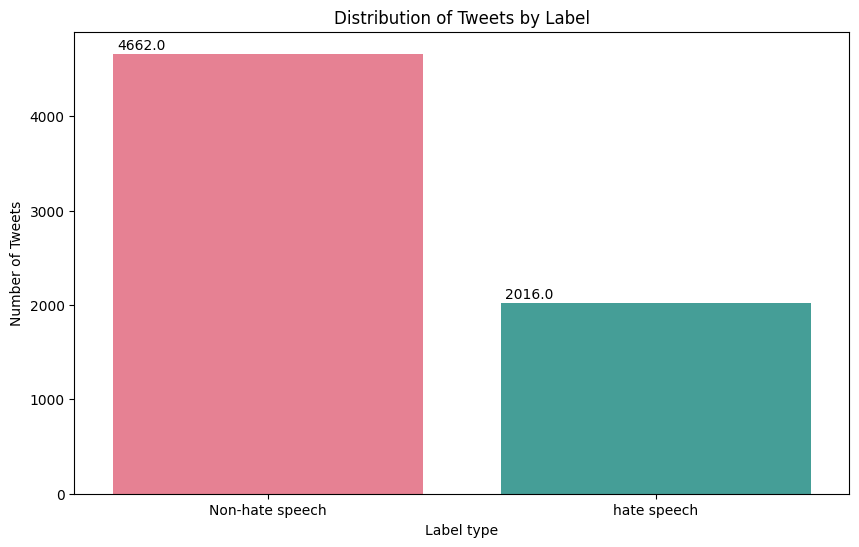

In [97]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
          x=df['label'].value_counts().index,
          y=df['label'].value_counts().values,
          palette="husl")

ax.set_xticklabels(['Non-hate speech', 'hate speech'])

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))

plt.xlabel('Label type')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Label')
plt.show()

## Balance Dataset

In [98]:
# Get the counts of each label
label_0_count = df['label'].value_counts()[0]
label_1_count = df['label'].value_counts()[1]

# Separate the data into two subsets based on labels
label_0_data = df[df['label'] == 0]
label_1_data = df[df['label'] == 1]


# Undersample label 0 to match the count of label 1
label_0_undersampled = label_0_data.sample(label_1_count, random_state=42)

# Combine undersampled label 0 data with label 1 data
balanced_data = pd.concat([label_0_undersampled, label_1_data])

In [99]:
# Check if data is well balanced
balanced_data['label'].value_counts()

,count
label,
0,2016
1,2016


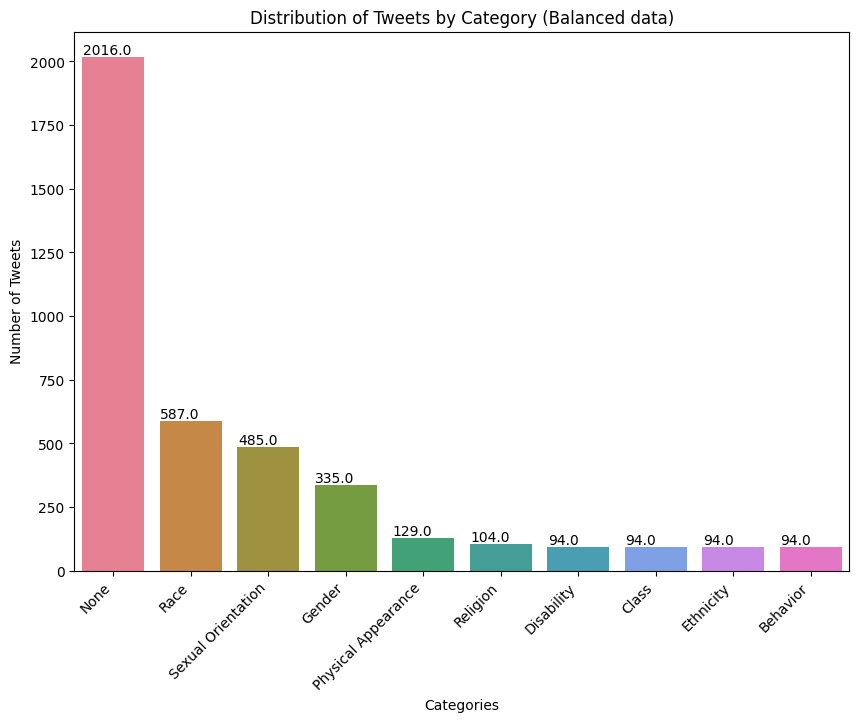

In [100]:
plt.figure(figsize=(10,7))
ax = sns.barplot(
          x=balanced_data['categories'].value_counts().index,
          y=balanced_data['categories'].value_counts().values,
          palette="husl")

ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 10))

plt.xticks(rotation=45, ha='right')
plt.xlabel('Categories')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Category (Balanced data)')
plt.show()

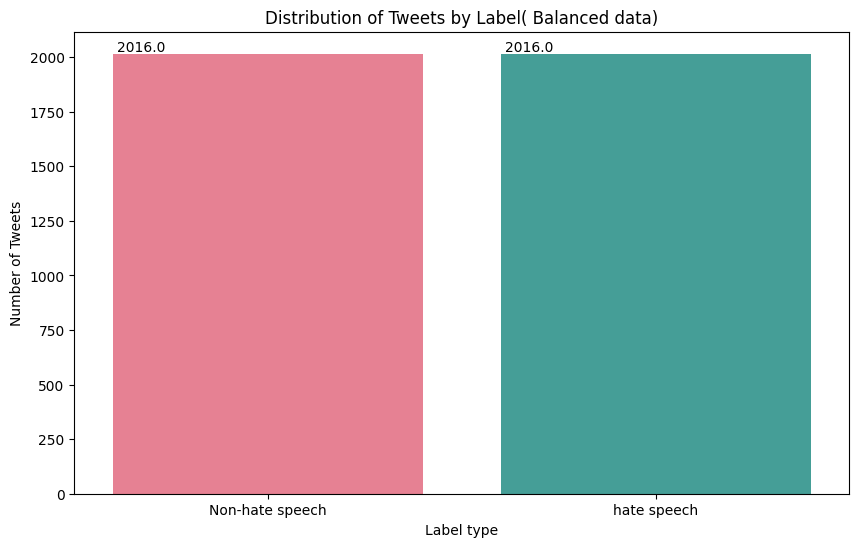

In [101]:
plt.figure(figsize=(10,6))
ax = sns.barplot(
          x=balanced_data['label'].value_counts().index,
          y=balanced_data['label'].value_counts().values,
          palette="husl")

ax.set_xticklabels(['Non-hate speech', 'hate speech'])

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 10))

plt.xlabel('Label type')
plt.ylabel('Number of Tweets')
plt.title('Distribution of Tweets by Label( Balanced data)')
plt.show()

In [102]:
# Shuffle the dataset to mix the labels
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [103]:
# Save the balanced dataset to a new CSV file
balanced_file_path = 'balanced_dataset.csv'
balanced_data.to_csv(balanced_file_path, index=False)

In [104]:
# save the balanced dataset to a new json file
# balanced_file_path = 'balanced_dataset.json'
# balanced_data.to_json(balanced_file_path, orient='records')

In [105]:
unbalanced_data_df = df.copy()
unbalanced_data_df

,tweet,label,categories
0,krazy i dont always get drunk and pass out but...,0,None
1,white kids favorite activities calling people ...,1,Race
2,maam did you clear that tweet with the caref...,0,None
3,wth is that playing missy i mean seriously rt...,0,None
4,he promised to stand with the muzzies so,0,None
...,...,...,...
995,happy morning 8degree with anna #classmate #fr...,0,None
996,I don't work this hard so that those Hispanics...,1,Race
997,Britain without Muslims,1,Religion
998,refugees must leave our country,1,Race


In [106]:
unbalanced_data_df = df.copy()
df = balanced_data
df

,tweet,label,categories
0,woahh ahha i remember her from charlie and the...,0,None
1,lakers really trash,0,None
2,ive also seen a lot of that were democrats and...,0,None
3,this is a joke right youre on here like ugh i ...,1,Race
4,its ok to trash talkbut i havent seen any bama...,0,None
...,...,...,...
4027,i hate being profiled im not country im not a ...,0,None
4028,mark teixeira finally stepping up hr and coupl...,0,None
4029,a yellow jacket landed on my mouth and stung m...,0,None
4030,bitch kill yoself go on to the bathroom and ea...,1,Gender


# Data Translation

## Google Translation API

In [107]:
#Google translate API key
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'mythic-cinema-435220-b6-9c61e511fdbe.json'

In [108]:
# Initialize the Google Translate API
def create_translate_client():
    return translate.Client()

In [109]:
# Function to translate text from English to isiZulu
def translate_text(client, text, target_language='zu'):
    result = client.translate(text, target_language=target_language)
    return result['translatedText']

In [110]:
# Function to process and translate text in batches
def batch_translate(df, text_column, target_language='zu', batch_size=100):
    translate_client = create_translate_client()

    # Split the data into batches
    translated_texts = []

    for i in tqdm(range(0, len(df), batch_size)):
        batch = df[text_column][i:i+batch_size].tolist()

        # Translate the batch
        translated_batch = [translate_text(translate_client, text, target_language) for text in batch]
        translated_texts.extend(translated_batch)

    return translated_texts

In [111]:
df['tweet'].isnull().value_counts()

,count
tweet,
False,4032


Start the Translation

In [112]:
# Translate the data to isiZulu
#df['translated_Zulu'] = batch_translate(df, 'tweet')

In [113]:
df

,tweet,label,categories
0,woahh ahha i remember her from charlie and the...,0,None
1,lakers really trash,0,None
2,ive also seen a lot of that were democrats and...,0,None
3,this is a joke right youre on here like ugh i ...,1,Race
4,its ok to trash talkbut i havent seen any bama...,0,None
...,...,...,...
4027,i hate being profiled im not country im not a ...,0,None
4028,mark teixeira finally stepping up hr and coupl...,0,None
4029,a yellow jacket landed on my mouth and stung m...,0,None
4030,bitch kill yoself go on to the bathroom and ea...,1,Gender


In [114]:
# Download DataFrame for manual analysis

#df.to_csv('translated_balanced_data.csv', index=False)
#files.download('translated_balanced_data.csv')

df = pd.read_csv('translated_balanced_data.csv')

### Semantic Analysis

In [115]:
# Array for Stopping words
zulu_stop_words = []
# Zulu stop words
zulu_stop_words.extend(['i', 'ukuthi', 'ama', 'u', 'futhi', 'uma', 'wena', 'abantu', 'kodwa', 'ku', 'rt'])
zulu_stop_words.extend(['a', 'e', 'noma', 'yakho', 'nje', 'wonke', 'we', 'lol', 'le', 'yami', 'you', 'amp'])
zulu_stop_words.extend(['umuntu', 'ngoba', 'kakhulu', 'uyi', 'kufanele', 'ye', 'lokho', 'the', 'yini', 'ne'])
zulu_stop_words.extend(['be', 'ngakho', 'njenge', 'im', 'yall', 'ma', 'ke', 'kuphela', 'bonke', 'lapha', 'kanjani'])
zulu_stop_words.extend(['wami', 'bese', 'sengathi', 'wakho', 'that', 'no', 'smh', 'of', 'to', 'yakhe', 'manje'])
zulu_stop_words.extend(['dyke', 'ngempela',' yo', 'kungani', 'ngaphandle', 'yo', 'kungani', 'ngaphandle'])
zulu_stop_words.extend(['and', 'me', 'coon', 'lmao', 'zonke', 'ze', 'njengoba', 'lowo', 'ngeke', 'nama']) # izingane
zulu_stop_words.extend(['into', 'kahle', 'oh', 'uthole', 'yebo', 'lo', 'hamba', 'lezi', 'bamba'])
zulu_stop_words.extend(['lami', 'are', 'ngifuna', 'lawa', 'aint', 'is', 'usuku', 'cracker', 'up', 'nawe', 'ukuba'])
zulu_stop_words.extend(['yi', 'cha', 'not', '39', 'america', 'igama', 'spic', 'abe', 'kukhona', 'nina', 'yonke', 'encane'])
zulu_stop_words.extend(['jason', 'sakho', 'ngokuthi', 'sami', 'uthi', 'ur', 'leyo', 'ngabe', 'dat', 'angikwazi', 'isikhathi'])
zulu_stop_words.extend(['its', 'wakhe', 'buka', 'ngayo', 'kulungile', 'like', 'lawo','twitter', 'man', 'ukwenza', 'kimi'])
zulu_stop_words.extend(['kube', 'kabi', 'labo', 'akekho', 'akukho', 'akekho', 'nami', 'lil', 'eyodwa', 'cishe'])
zulu_stop_words.extend(['ucanbanga', 'dont', 'lmfao', 'indawo', 'this', 'ami', 'lakho', 'kanye', 'oreo', 'oreos', 'charlie'])
zulu_stop_words.extend(['for', 'lelo', 'so', 'se', 'zakho', 'just', '@user', 'u-charlie', 'lapho', 'nge', 'lokhu', 'bami'])
zulu_stop_words.extend(['ngenxa', 'khona', 'leli', 'ukudla', 'they', 'ubani', 'wethu', 'ngisho', 'esikoleni', 'sabo', 'kabili'])
zulu_stop_words.extend([''])

In [116]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.translated_Zulu)
# Display the first 15 words
corpus[:15]

['woahh',
 'ahha',
 'ngimkhumbula',
 'ku',
 'charlie',
 'nasembonini',
 'kashokoledi',
 'ucabanga',
 'ukuthi',
 'ubani',
 'owabulala',
 'uLucy',
 'ngicabanga',
 'ukuthi',
 'u-abby']

In [117]:
counter = Counter(corpus)
most_common = counter.most_common(100)
most_common = pd.DataFrame(most_common, columns=['word', 'count'])
most_common.head(50)

,word,count
0,ukuthi,504
1,futhi,415
2,uma,218
3,abantu,174
4,udoti,169
5,kodwa,167
6,kakhulu,163
7,noma,158
8,kufanele,111
9,nje,106


Check Most occuring hateful words

In [118]:
# Filter for label 1
label_1_texts = df[df['label'] == 1]['translated_Zulu'].astype(str)
filtered = []

# Tokenize the text
def tokenize(text):
    # Remove non-alphabetic characters and split text
    tokens = re.findall(r'\b\w+\b', text.lower())
    return tokens

for text in label_1_texts:
    tokens = tokenize(text)
    # Filter out stop words
    filtered_tokens = [word for word in tokens if word not in zulu_stop_words]
    filtered.extend(filtered_tokens)

# Count word frequencies after excluding stop words
word_freq_filtered = Counter(filtered)

# Get the most common words
most_common_words_filtered = word_freq_filtered.most_common(100)

# Create a DataFrame for better presentation
df_freq_filtered = pd.DataFrame(most_common_words_filtered, columns=['Word', 'Frequency'])


print(df_freq_filtered.head(50))

              Word  Frequency
0            nigga        123
1            fagot        122
2           nigger         98
3           niggas         73
4        nondindwa         67
5            bitch         62
6             fuck         55
7         omhlophe         52
8            udoti         49
9            ukuze         49
10            shit         46
11         niggers         46
12             ass         44
13          fagots         42
14     abesifazane         42
15             fag         42
16       imbongolo         40
17         ingquza         39
18         bitches         33
19  abakhubazekile         29
20           pussy         25
21        izingane         25
22          fuckin         24
23         fucking         24
24       izitabane         22
25             gay         22
26          bhebha         21
27           ukufa         21
28       ngendlela         21
29         abadala         20
30       abamnyama         20
31         amageja         19
32        

In [119]:
print(df_freq_filtered.tail(50))

             Word  Frequency
50   ngingajabula         14
51           fags         14
52           embi         14
53         indoda         13
54      ukubhebha         13
55  amantombazane         13
56       emhlophe         13
57      akufanele         13
58     ayavilapha         13
59           stfu         13
60            nig         12
61         kadoti         12
62           doti         12
63   emphakathini         12
64          black         11
65           nabo         11
66          kwami         11
67          lutho         11
68         omunye         11
69          islam         11
70          thula         11
71        amadoda         11
72         kumele         11
73         phansi         10
74         kuleli         10
75     ngicabanga         10
76        ngicela         10
77         abanye         10
78           babe         10
79          bantu         10
80         kokuba         10
81          eduze         10
82          hhayi         10
83           e

## Refined Translated Data

Chatgpt was used to get the refined translated data

In [120]:
# read in data
refined_df = pd.read_csv('refined_translated_balanced_data.csv')

In [121]:
refined_df.head(10)

,tweet,label,categories,translated_Zulu,refined_translated_Zulu
0,woahh ahha i remember her from charlie and the...,0,NaN,woahh ahha ngimkhumbula ku charlie nasembonini...,woahh ahha ngimkhumbula ku charlie nasembonini...
1,lakers really trash,0,NaN,Lakers udoti ngempela,Lakers izinto ezingcolile ngempela
2,ive also seen a lot of that were democrats and...,0,NaN,ngiphinde ngabona okuningi okwakungamademokhra...,ngiphinde ngabona okuningi okwakungamademokhra...
3,this is a joke right youre on here like ugh i ...,1,Race,ihlaya leli elikhona lapha ngathi ugh ngifisa ...,ihlaya leli elikhona lapha ngathi ugh ngifisa ...
4,its ok to trash talkbut i havent seen any bama...,0,NaN,kulungile ukulahla inkulumo kodwa angikaze ngi...,kulungile ukulahla inkulumo kodwa angikaze ngi...
5,i just caught myself eating chocolate sliced b...,0,NaN,ngizibambe nje ngidla isinkwa esisikiwe sika c...,ngizibambe nje ngidla isinkwa esisikiwe sika c...
6,my mother be on some trash man i ask her ever...,0,NaN,umama wami abe on some trash man ngimbuza ever...,umama wami abe on some trash man ngimbuza ever...
7,ill slit your throatneck,0,NaN,ngizokunquma umphimbo wakho,ngizokunquma umphimbo wakho
8,Foreigners take our jobs,1,Race,Abezinye izizwe bathatha imisebenzi yethu,Abezinye izizwe bathatha imisebenzi yethu
9,parodies of jihadi songs more effective than ...,0,NaN,ama-parodies wezingoma zama-jihadi asebenza ka...,ama-parodies wezingoma zama-jihadi asebenza ka...


In [122]:
# Replace null category column with "None"
refined_df["categories"] = refined_df["categories"].fillna("None")

# Word Cloud

(-0.5, 999.5, 499.5, -0.5)

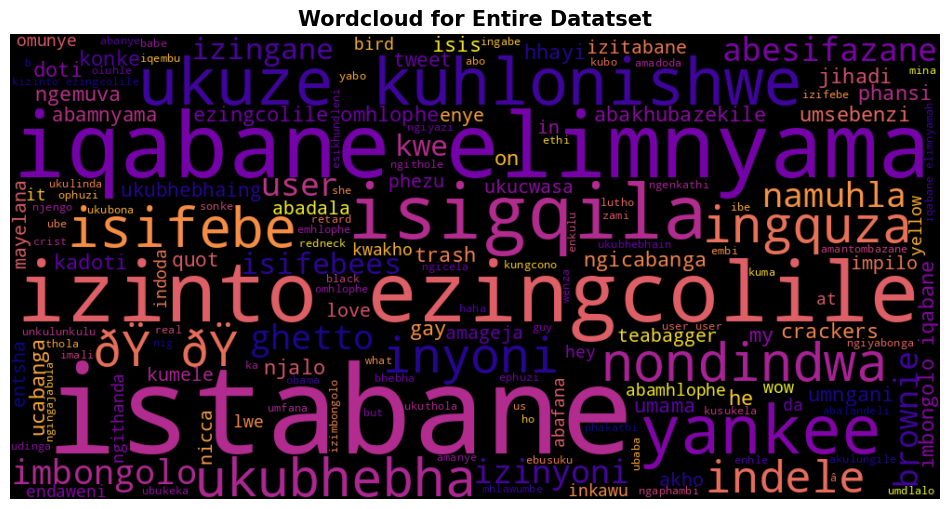

In [123]:
# wordcloud for entire dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=500,
               width=1000,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=zulu_stop_words).generate(' '.join(refined_df.refined_translated_Zulu))

plt.title("Wordcloud for Entire Datatset", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

(-0.5, 999.5, 499.5, -0.5)

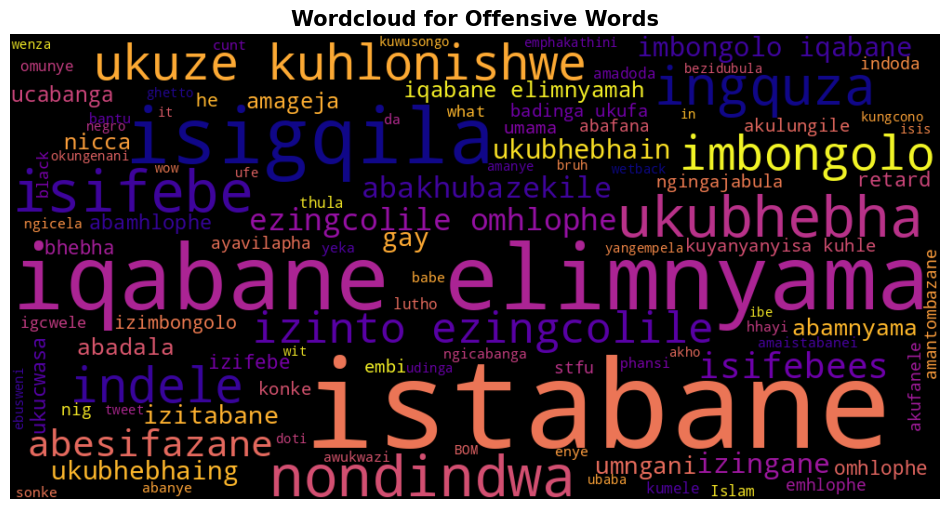

In [124]:
# Word cloud for Non-Hate Speech (Label 0)
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=100,
               min_font_size=10,
               height=500,
               width=1000,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=zulu_stop_words).generate(' '.join(refined_df[refined_df['label'] == 1]['refined_translated_Zulu']))

plt.title("Wordcloud for Offensive Words", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

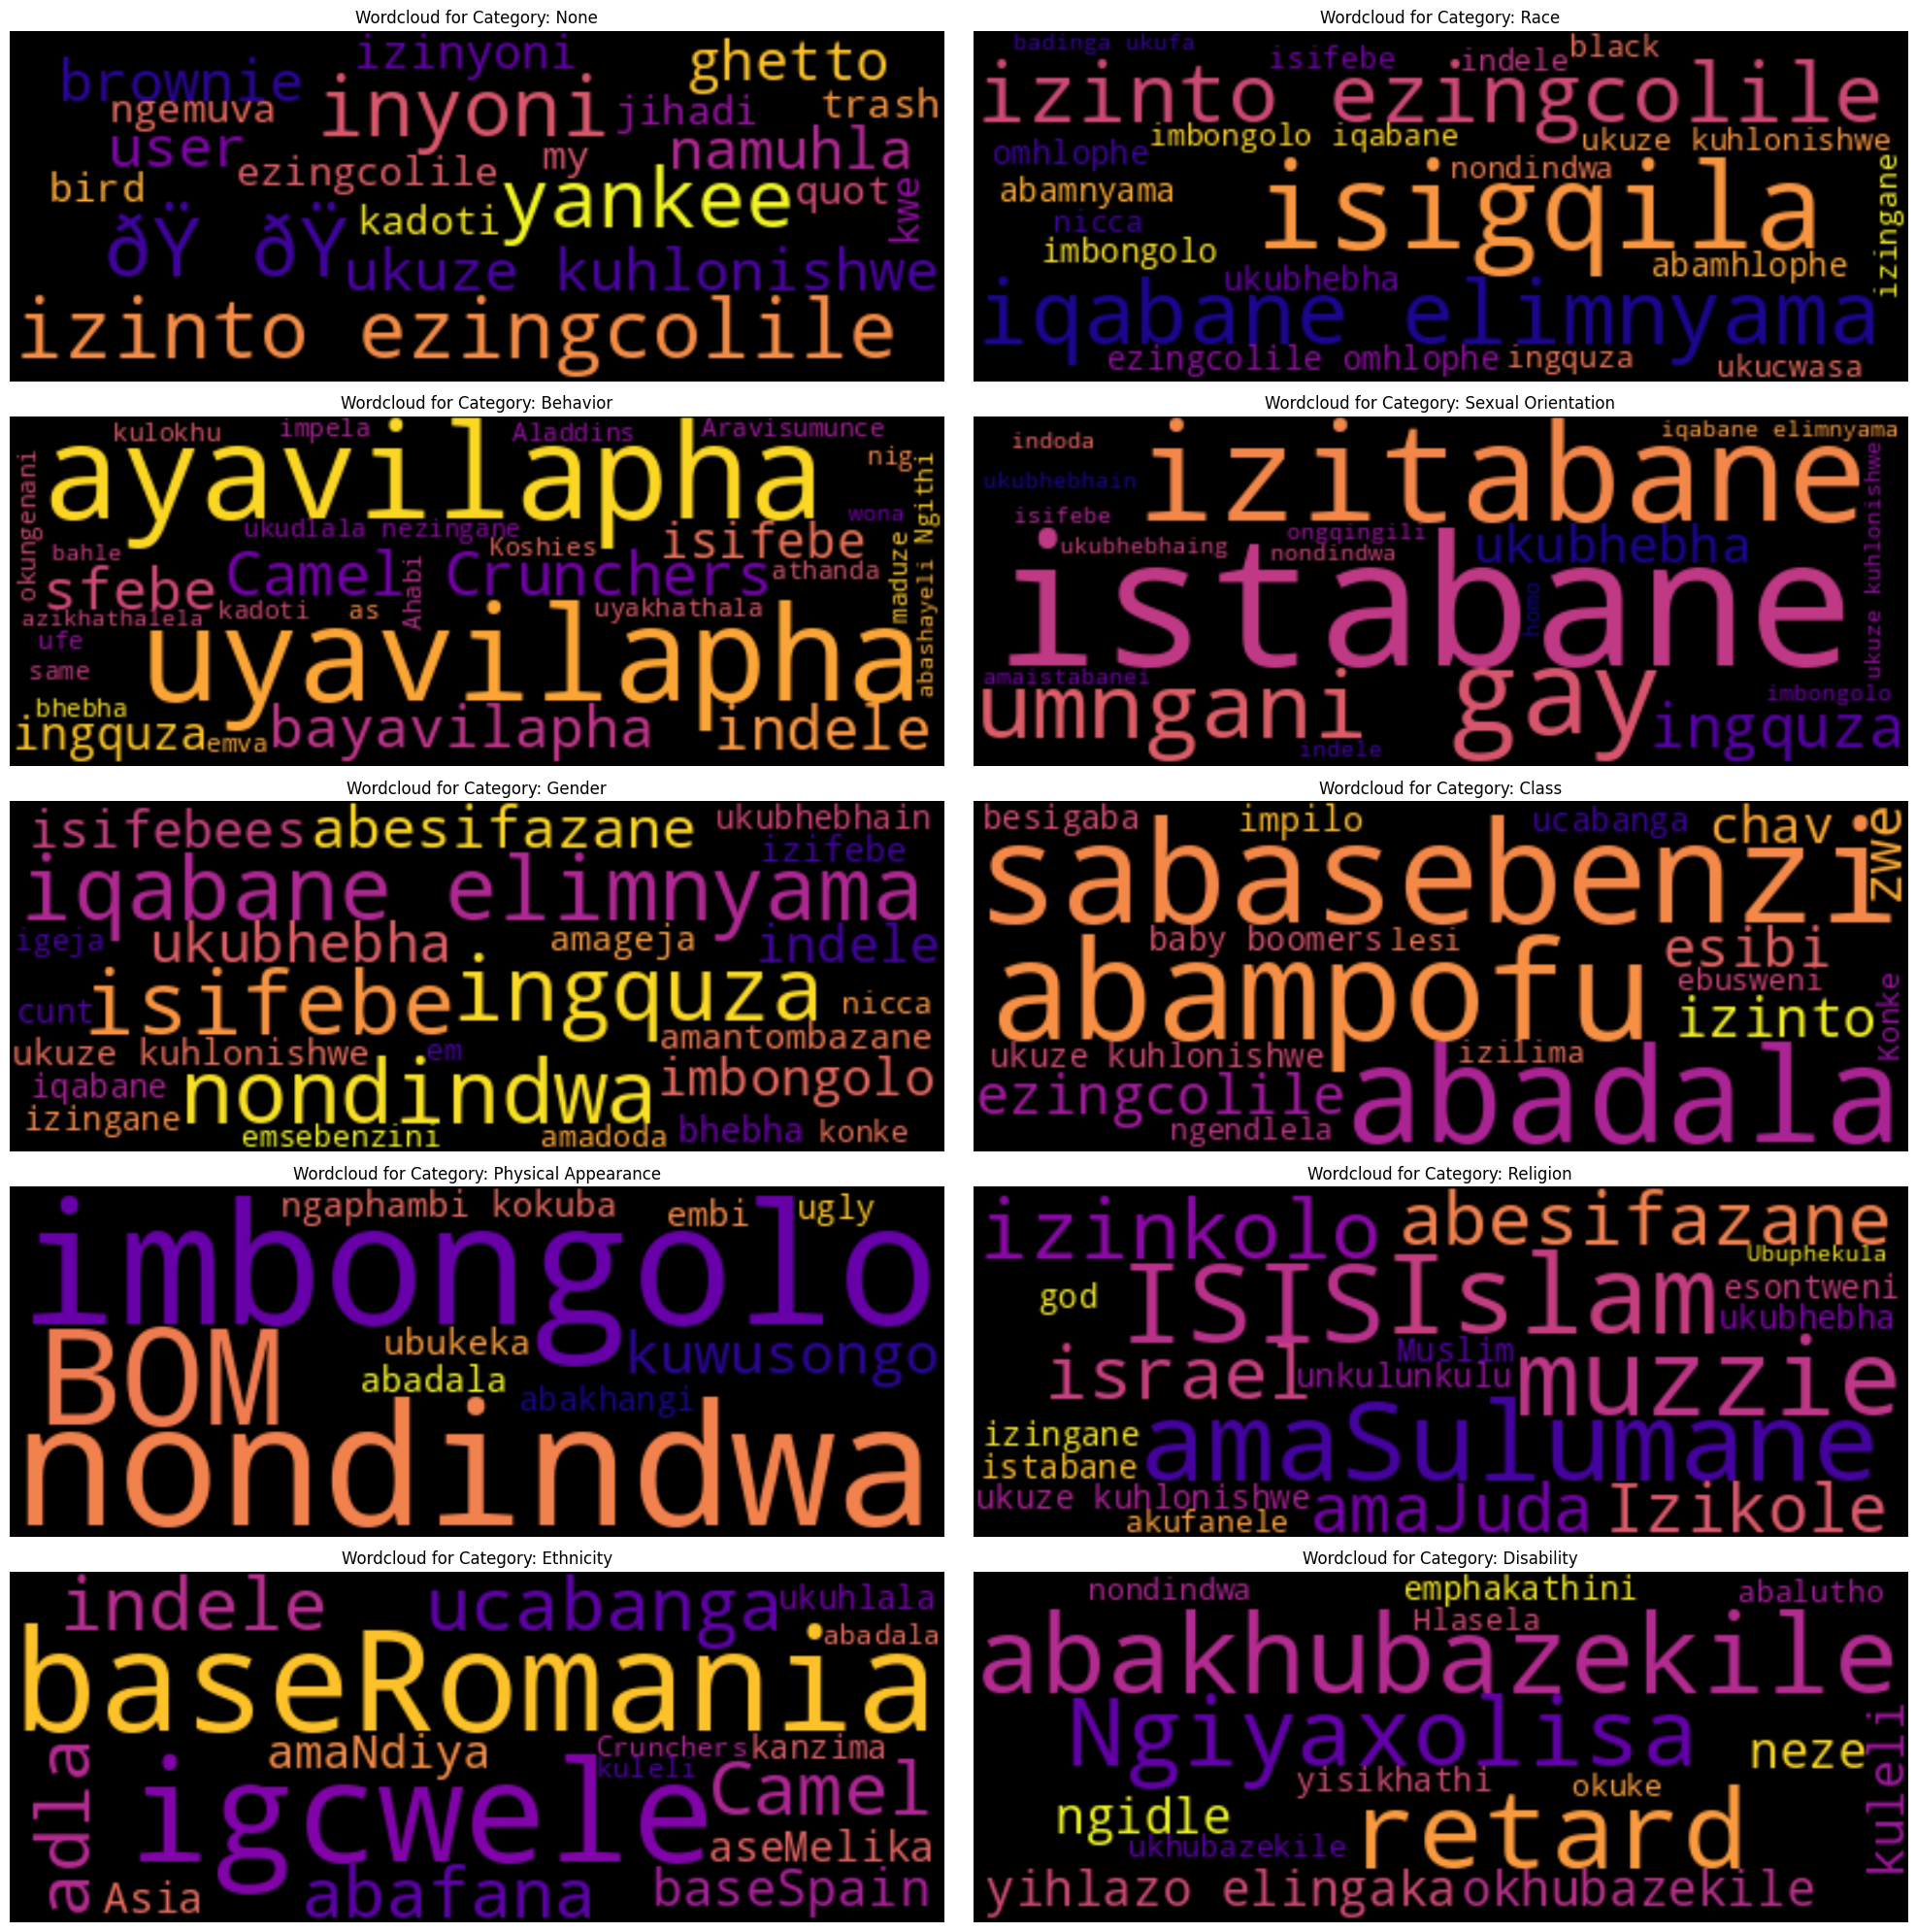

In [125]:
# List of categories in the dataset
categories = refined_df['categories'].dropna().unique().tolist()

# List of Zulu translations for each category
articles_list = []

for i in categories:
    cat_ndf = refined_df[refined_df['categories'] == i]
    cat_array = cat_ndf['refined_translated_Zulu'].values  # array of Zulu translations in each category
    articles_list.append(cat_array)

# Create a WordCloud instance
wc1 = WordCloud(max_words=50,
                min_font_size=10,
                height=150,
                width=400,
                background_color='black',
                contour_color='black',
                colormap='plasma',
                repeat=True,
                stopwords=zulu_stop_words)

# Plot the figure of word clouds for each category
plt.figure(figsize=(20, 20))

for idx, category in enumerate(categories):
    plt.subplot(5, 2, idx + 1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation="bilinear")
    plt.title(f"Wordcloud for Category: {category}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Models

In [126]:
df

,tweet,label,categories,translated_Zulu
0,woahh ahha i remember her from charlie and the...,0,NaN,woahh ahha ngimkhumbula ku charlie nasembonini...
1,lakers really trash,0,NaN,Lakers udoti ngempela
2,ive also seen a lot of that were democrats and...,0,NaN,ngiphinde ngabona okuningi okwakungamademokhra...
3,this is a joke right youre on here like ugh i ...,1,Race,ihlaya leli elikhona lapha ngathi ugh ngifisa ...
4,its ok to trash talkbut i havent seen any bama...,0,NaN,kulungile ukulahla inkulumo kodwa angikaze ngi...
...,...,...,...,...
4027,i hate being profiled im not country im not a ...,0,NaN,ngiyakuzonda ukufakwa iphrofayili hhayi izwe a...
4028,mark teixeira finally stepping up hr and coupl...,0,NaN,umaka i-teixeira ekugcineni ekhuphuka ngo-hr k...
4029,a yellow jacket landed on my mouth and stung m...,0,NaN,ijakhethi ephuzi lahlala emlonyeni wami langil...
4030,bitch kill yoself go on to the bathroom and ea...,1,Gender,nondindwa zibulale ngena endlini encane udle a...


In [127]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split


X = refined_df['refined_translated_Zulu']
encoder = LabelEncoder()
y = encoder.fit_transform(refined_df['label'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

shape of input data:  (4032,)
shape of target variable:  (4032,)


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Convert text data into numerical data using TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # Use 5000 most common words
X_tfidf = tfidf.fit_transform(X_train)  # Fit TF-IDF on X_train and transform it

# Split data into train and test sets (70% train, 30% test)
X_train_tfidf, X_test_tfidf, y_train_encoded, y_test_encoded = train_test_split(X_tfidf, y_train, test_size=0.3, random_state=42)

# Encode labels into integers if necessary
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_encoded)
y_test_encoded = label_encoder.transform(y_test_encoded)


In [130]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# SVM model
svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train_encoded)
svm_pred = svm_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test_encoded, svm_pred)

# Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_train_tfidf, y_train_encoded)
rf_pred = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test_encoded, rf_pred)

# Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train_encoded)
lr_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test_encoded, lr_pred)

# Print the accuracy results
print(f"SVM Accuracy: {svm_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")
print(f"Logistic Regression Accuracy: {lr_accuracy}")


SVM Accuracy: 0.8149779735682819
Random Forest Accuracy: 0.7874449339207048
Logistic Regression Accuracy: 0.8105726872246696


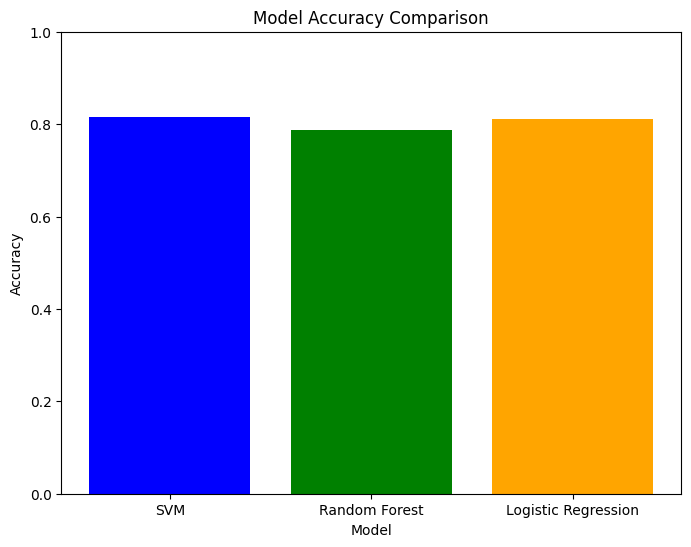

In [131]:
import matplotlib.pyplot as plt

# Accuracies of the models
model_names = ['SVM', 'Random Forest', 'Logistic Regression']
accuracies = [svm_accuracy, rf_accuracy, lr_accuracy]

# Plotting the accuracies
plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracies, color=['blue', 'green', 'orange'])
plt.ylim(0, 1)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.show()


In [132]:
from sklearn.metrics import precision_score, recall_score, f1_score

# SVM model
svm_pred = svm_model.predict(X_test_tfidf)
svm_accuracy = accuracy_score(y_test_encoded, svm_pred)
svm_precision = precision_score(y_test_encoded, svm_pred, average='weighted')
svm_recall = recall_score(y_test_encoded, svm_pred, average='weighted')
svm_f1 = f1_score(y_test_encoded, svm_pred, average='weighted')

# Random Forest model
rf_pred = rf_model.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test_encoded, rf_pred)
rf_precision = precision_score(y_test_encoded, rf_pred, average='weighted')
rf_recall = recall_score(y_test_encoded, rf_pred, average='weighted')
rf_f1 = f1_score(y_test_encoded, rf_pred, average='weighted')

# Logistic Regression model
lr_pred = lr_model.predict(X_test_tfidf)
lr_accuracy = accuracy_score(y_test_encoded, lr_pred)
lr_precision = precision_score(y_test_encoded, lr_pred, average='weighted')
lr_recall = recall_score(y_test_encoded, lr_pred, average='weighted')
lr_f1 = f1_score(y_test_encoded, lr_pred, average='weighted')


In [133]:
# Combine the metrics into a dictionary for easier plotting
metrics = {
    'SVM': {
        'Accuracy': svm_accuracy,
        'Precision': svm_precision,
        'Recall': svm_recall,
        'F1-Score': svm_f1
    },
    'Random Forest': {
        'Accuracy': rf_accuracy,
        'Precision': rf_precision,
        'Recall': rf_recall,
        'F1-Score': rf_f1
    },
    'Logistic Regression': {
        'Accuracy': lr_accuracy,
        'Precision': lr_precision,
        'Recall': lr_recall,
        'F1-Score': lr_f1
    }
}

# Convert this into a format that can be easily plotted
import pandas as pd
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.T  # Transpose for easier plotting
print(df_metrics)  # To check the results

                     Accuracy  Precision    Recall  F1-Score
SVM                  0.814978   0.822019  0.814978  0.814402
Random Forest        0.787445   0.789987  0.787445  0.786579
Logistic Regression  0.810573   0.812472  0.810573  0.810514


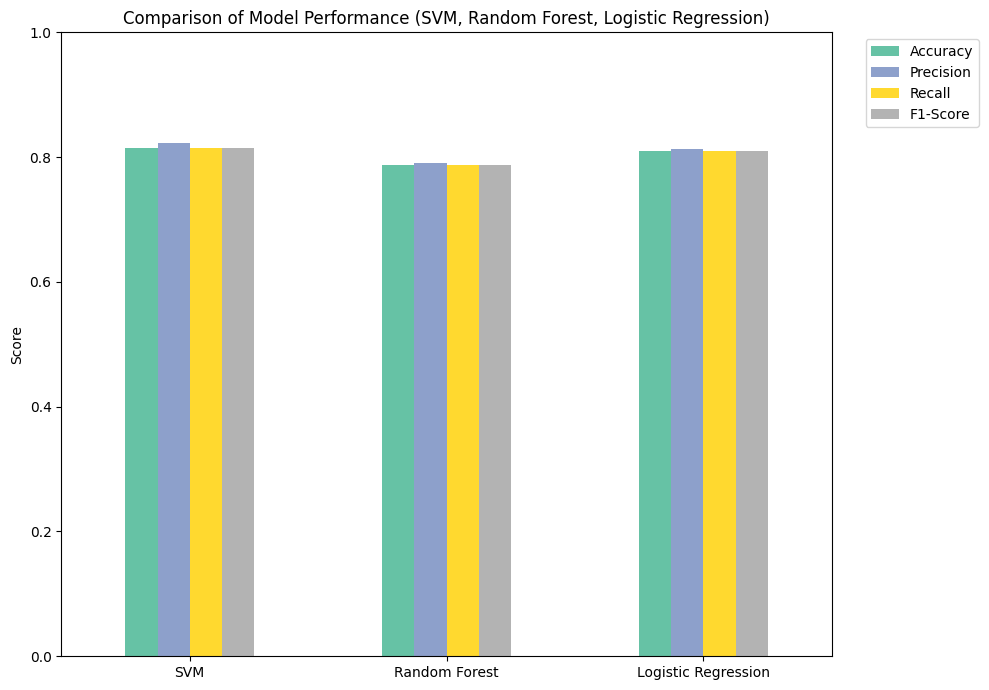

In [134]:
# Plotting the metrics
df_metrics.plot(kind='bar', figsize=(10, 7), colormap='Set2')

# Adding plot aesthetics
plt.title('Comparison of Model Performance (SVM, Random Forest, Logistic Regression)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()
plt.show()


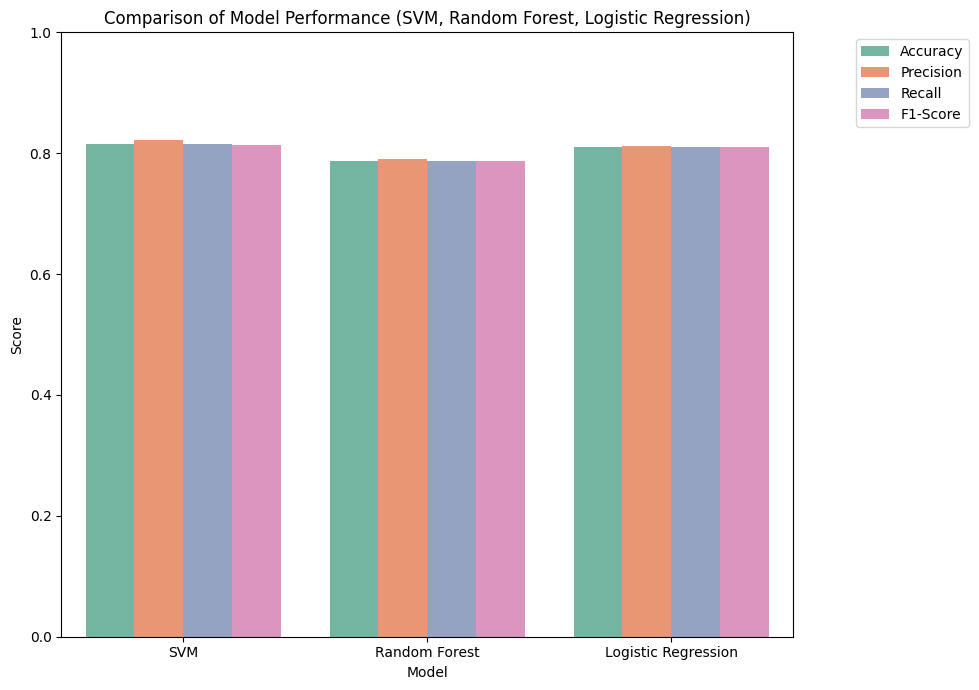

In [135]:
df_metrics = pd.DataFrame(metrics).T

# Convert DataFrame to a format compatible with seaborn
df_metrics_melted = df_metrics.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')

# Plot the metrics using seaborn
plt.figure(figsize=(10, 7))
sns.barplot(x='index', y='Score', hue='Metric', data=df_metrics_melted, palette='Set2')

# Adding plot aesthetics
plt.title('Comparison of Model Performance (SVM, Random Forest, Logistic Regression)')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0))
plt.tight_layout()
plt.show()

# Add values on top of each bar
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Only annotate positive values
        ax.annotate(f'{height:.2f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center',
                    xytext=(0, 1),
                    textcoords='offset points')

plt.show()